
# Be careful when interpreting predictive models in search of causal insights

An examplary case study for the causal & prediction task, confounding or redudant features

https://shap.readthedocs.io/en/stable/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html

In [1]:

# This cell defines the functions we use to generate the data in our scenario

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost

class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

# generate the data
def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # the number of sales calls made to this customer
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # the number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # the health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # the time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # how much the user perceives that they need the product
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # the fractional discount offered to this customer upon renewal
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # What percent of the days in the last period was the user actively using the product
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # how much ad money we spent per user targeted at this user (or a group this user is in)
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # how many bugs did this user encounter in the since their last renewal
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # how many bugs did the user report?
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # did the user renew?
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Uncomment this line to get
    # noiser causal effect lines but the same basic results
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

In [2]:
X, y = user_retention_dataset()
model = fit_xgboost(X, y)

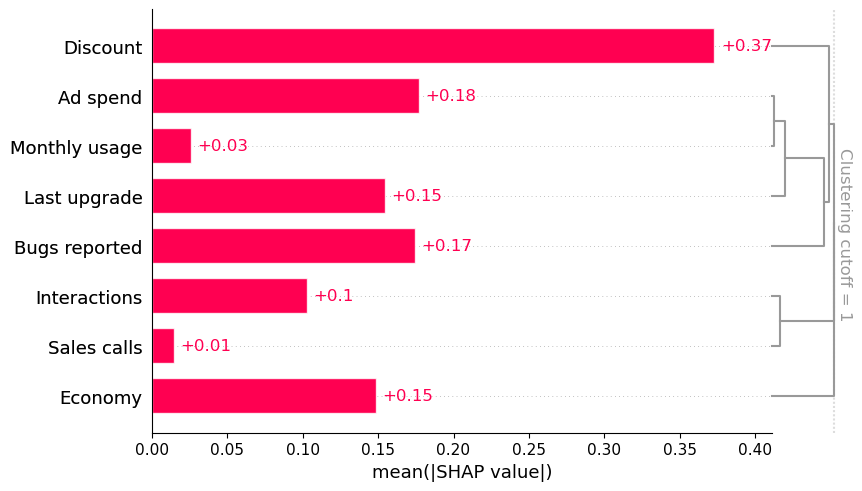

In [3]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

This bar plot shows that the discount offered, ad spend, and number of bugs reported are the top three factors driving the model’s prediction of customer retention. This is interesting and at first glance looks reasonable. The bar plot also includes a feature redundancy clustering which we will use later.

However, when we dig deeper and look at how changing the value of each feature impacts the model’s prediction, we find some unintuitive patterns. SHAP scatter plots show how changing the value of a feature impacts the model’s prediction of renewal probabilities. If the blue dots follow an increasing pattern, this means that the larger the feature, the higher is the model’s predicted renewal probability.

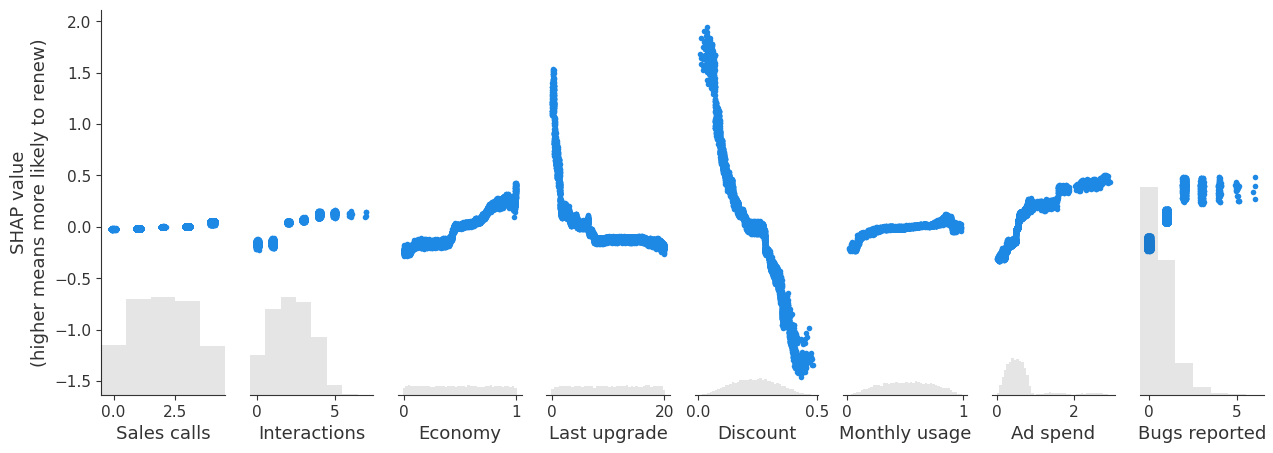

In [5]:
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")

The scatter plots show some surprising findings: - Users who report more bugs are more likely to renew! - Users with larger discounts are less likely to renew!

We triple-check our code and data pipelines to rule out a bug, then talk to some business partners who offer an intuitive explanation: - Users with high usage who value the product are more likely to report bugs and to renew their subscriptions. - The sales force tends to give high discounts to customers they think are less likely to be interested in the product, and these customers have higher churn.

Are these at-first counter-intuitive relationships in the model a problem? That depends on what our goal is!

Our original goal for this model was to predict customer retention, which is useful for projects like estimating future revenue for financial planning. Since users reporting more bugs are in fact more likely to renew, capturing this relationship in the model is helpful for prediction. As long as our model has good fit out-of-sample, we should be able to provide finance with a good prediction, and therefore shouldn’t worry about the direction of this relationship in the model.

However, suppose a second team picks up our prediction model with the new goal of determining what actions our company can take to retain more customers. This team cares a lot about how each X feature relates to Y, not just in our training distribution, but the counterfactual scenario produced when the world changes. In that use case, it is no longer sufficient to identify a stable correlation between variables; this team wants to know whether manipulating feature X will cause a change in Y. Picture the face of the chief of engineering when you tell him that you want him to introduce new bugs to increase customer renewals!

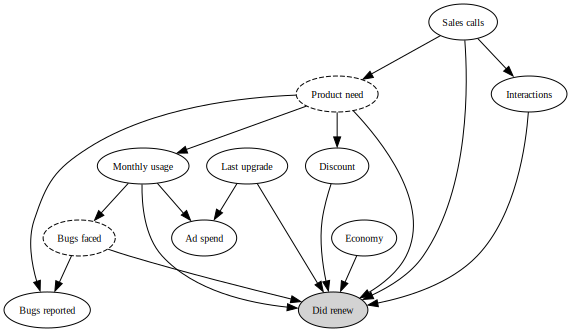

In [13]:
import graphviz
names = [
         "Bugs reported", "Monthly usage", "Sales calls", "Economy",
         "Discount", "Last upgrade", "Ad spend", "Interactions"
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")
g


A useful tool to understanding causal relationships is writing down a causal graph of the data generating process we’re interested in. A causal graph of our example illustrates why the robust predictive relationships picked up by our XGBoost customer retention model differ from the causal relationships of interest to the team that wants to plan interventions to increase retention. This graph is just a summary of the true data generating mechanism (which is defined above). Solid ovals represent features that we observe, while dashed ovals represent hidden features that we don’t measure. Each feature is a function of all the features with an arrow to it, plus some random effects.

In our example we know the causal graph because we simulate the data. In practice the true causal graph will not be known, but we may be able to use context-specific domain knowledge about how the world works to infer which relationships can or cannot exist.

There are lots of relationships in this graph, but the first important concern is that some of the features we can measure are influenced by unmeasured confounding features like product need and bugs faced. For example, users who report more bugs are encountering more bugs because they use the product more, and they are also more likely to report those bugs because they need the product more. Product need has its own direct causal effect on renewal. Because we can’t directly measure product need, the correlation we end up capturing in predictive models between bugs reported and renewal combines a small negative direct effect of bugs faced and a large positive confounding effect from product need. The figure below plots the SHAP values in our example against the true causal effect of each feature (known in this example since we generated the data).

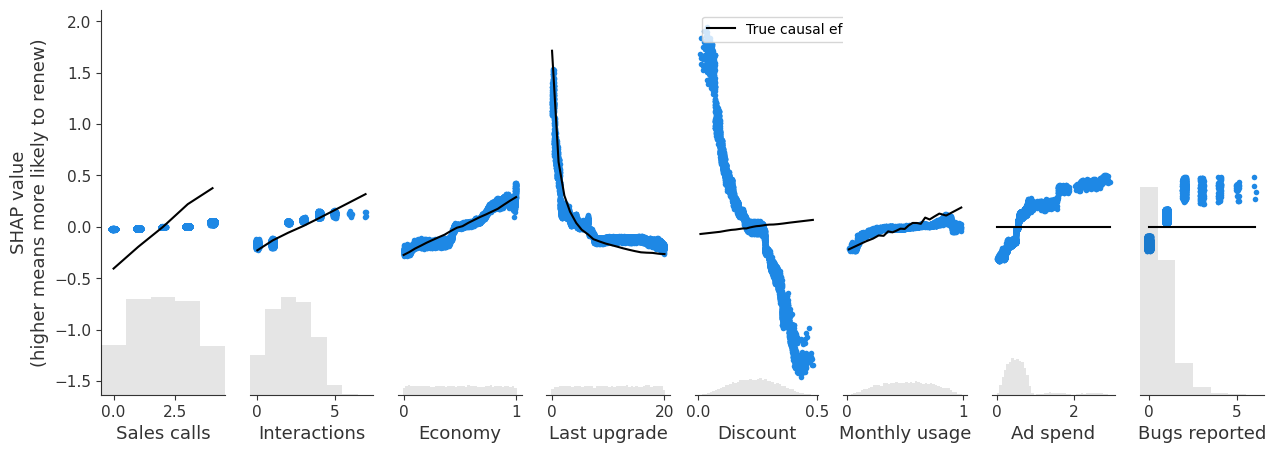

In [14]:
def marginal_effects(generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0):
    """ Helper function to compute the true marginal causal effects.
    """
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i,c in enumerate(columns):
        xs[i] = np.unique([np.nanpercentile(xs[i], v, method='nearest') for v in np.linspace(0, 100, max_points)])
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))

shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)", overlay={
    "True causal effects": marginal_effects(generator, 10000, X.columns)
})

The predictive model captures an overall positive effect of bugs reported on retention (as shown with SHAP), even though the causal effect of reporting a bug is zero, and the effect of encoutering a bug is negative.

We see a similar problem with Discounts, which are also driven by unobserved customer need for the product. Our predictive model finds a negative relationship between discounts and retention, driven by this correlation with the unobserved feature, Product Need, even though there is actually a small positive causal effect of discounts on renewal! Put another way, if two customers with have the same Product Need and are otherwise similar, then the customer with the larger discount is more likely to renew.

This plot also reveals a second, sneakier problem when we start to interpret predictive models as if they were causal. Notice that Ad Spend has a similar problem - it has no causal effect on retention (the black line is flat), but the predictive model is picking up a positive effect!

In this case, Ad Spend is only driven by Last Upgrade and Monthly Usage, so we don’t have an unobserved confounding problem, instead we have an observed confounding problem. There is statistical redundancy between Ad Spend and features that influence Ad Spend. When we have the same information captured by several features, predictive models can use any of those features for prediction, even though they are not all causal. While Ad Spend has no causal effect on renewal itself, it is strongly correlated with several features that do drive renewal. Our regularized model identifies Ad Spend as a useful predictor because it summarizes multiple causal drivers (so leading to a sparser model), but that becomes seriously misleading if we start to interpret it as a causal effect.



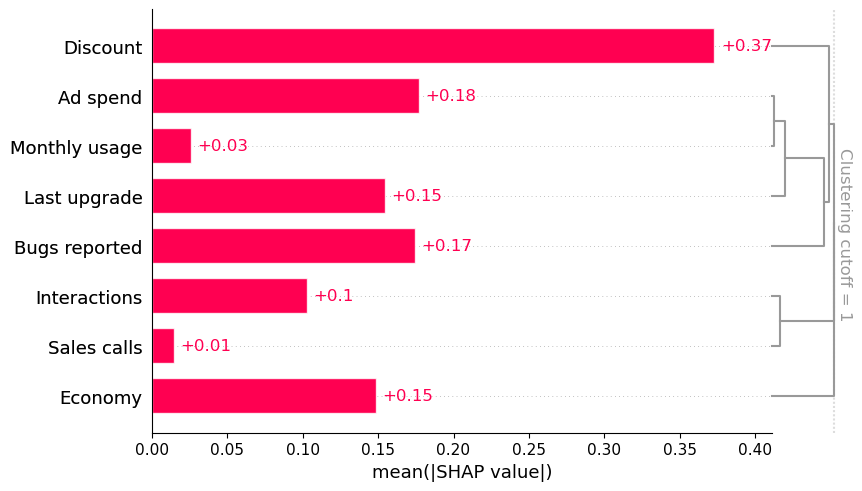

In [15]:
# Economy is independent of other measured features.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

Since we have added clustering to the right side of the SHAP bar plot we can see the redundancy structure of our data as a dendrogram. When features merge together at the bottom (left) of the dendrogram it means  that the information those features contain about the outcome (renewal) is very redundant and the model could have used either feature. When features merge together at the top (right) of the dendrogram it means the information they contain about the outcome is independent from each other.

We can see that Economy is independent from all the other measured features by noting that Economy does not merge with any other features until the very top of the clustering dendrogram. This tells us that Economy does not suffer from observed confounding. But to trust that the Economy effect is causal we also need to check for unobserved confounding. Checking for unmeasured confounders is harder and requires using domain knowledge (provided by the business partners in our example above).

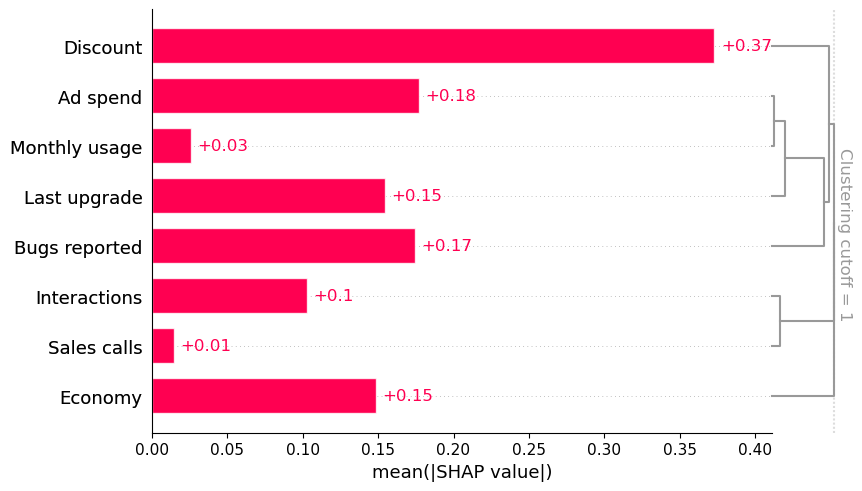

In [16]:
# Ad spend is very redundant with Monthly usage and Last upgrade.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

An example of this in our scenario is the Ad Spend feature. Even though Ad Spend has no direct causal effect on retention, it is correlated with the Last Upgrade and Monthly Usage features, which do drive retention. Our predictive model identifies Ad Spend as the one of the best single predictors of retention because it captures so many of the true causal drivers through correlations. XGBoost imposes regularization, which is a fancy way of saying that it tries to choose the simplest possible model that still predicts well. If it could predict equally well using one feature rather than three, it will tend to do that to avoid overfitting. But this means that if Ad Spend is highly correlated with both Last Upgrade and Monthly Usage, XGBoost may use Ad Spend instead of the causal features! This property of XGBoost (or any other machine learning model with regularization) is very useful for generating robust predictions of future retention, but not good for understanding which features we should manipulate if we want to increase retention.

In [24]:
from econml.dml import LinearDML
from sklearn.base import BaseEstimator, clone
import matplotlib.pyplot as plt

class RegressionWrapper(BaseEstimator):
    """ Turns a classifier into a 'regressor'.

    We use the regression formulation of double ML, so we need to approximate the classifer
    as a regression model. This treats the probabilities as just quantitative value targets
    for least squares regression, but it turns out to be a reasonable approximation.
    """
    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y, **kwargs):
        self.clf_ = clone(self.clf)
        self.clf_.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]

# Run Double ML, controlling for all the other features
def double_ml(y, causal_feature, control_features):
    """ Use doubleML from econML to estimate the slope of the causal effect of a feature.
    """
    xgb_model = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
    est = LinearDML(model_y=RegressionWrapper(xgb_model))
    est.fit(y, causal_feature, W=control_features)
    return est.effect_inference()

def plot_effect(effect, xs, true_ys, ylim=None):
    """ Plot a double ML effect estimate from econML as a line.

    Note that the effect estimate from double ML is an average effect *slope* not a full
    function. So we arbitrarily draw the slope of the line as passing through the origin.
    """
    plt.figure(figsize=(5, 3))

    pred_xs = [xs.min(), xs.max()]
    mid = (xs.min() + xs.max())/2
    pred_ys = [effect.pred[0]*(xs.min() - mid), effect.pred[0]*(xs.max() - mid)]

    plt.plot(xs, true_ys - true_ys[0], label='True causal effect', color="black", linewidth=3)
    point_pred = effect.point_estimate * pred_xs
    pred_stderr = effect.stderr * np.abs(pred_xs)
    plt.plot(pred_xs, point_pred - point_pred[0], label='Double ML slope', color=shap.plots.colors.blue_rgb, linewidth=3)
    # 99.9% CI
    plt.fill_between(pred_xs, point_pred - point_pred[0] - 3.291 * pred_stderr,
                     point_pred - point_pred[0] + 3.291 * pred_stderr, alpha=.2, color=shap.plots.colors.blue_rgb)
    plt.legend()
    plt.xlabel("Ad spend", fontsize=13)
    plt.ylabel("Zero centered effect")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.show()

# estimate the causal effect of Ad spend controlling for all the other features
causal_feature = "Ad spend"
control_features = [
    "Sales calls", "Interactions", "Economy", "Last upgrade", "Discount",
    "Monthly usage", "Bugs reported"
]
effect = double_ml(y, X[causal_feature], X.loc[:,control_features])

# plot the estimated slope against the true effect
xs, true_ys = marginal_effects(generator, 10000, X[["Ad spend"]], logit=False)[0]
plot_effect(effect, xs, true_ys, ylim=(-0.2, 0.2))

TypeError: __init__() got an unexpected keyword argument 'normalize'

Seems like a common error
like a bug

One particularly flexible tool for observational causal inference is double/debiased machine learning. It uses any machine learning model you want to first deconfound the feature of interest (i.e. Ad Spend) and then estimate the average causal effect of changing that feature (i.e. the average slope of the causal effect).

Double ML works as follows: 1. Train a model to predict a feature of interest (i.e. Ad Spend) using a set of possible confounders (i.e. any features not caused by Ad Spend). 2. Train a model to predict the outcome (i.e. Did Renew) using the same set of possible confounders. 3. Train a model to predict the residual variation of the outcome (the variation left after subtracting our prediction) using the residual variation of the causal feature of interest.

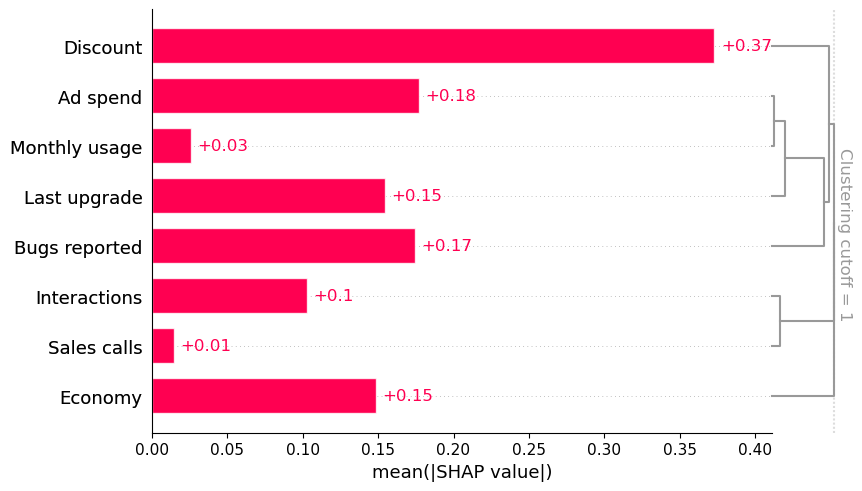

In [26]:
# Interactions and sales calls are very redundant with one another.
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

An example of this is the Sales Calls feature. Sales Calls directly impact retention, but also have an indirect effect on retention through Interactions. When we include both the Interactions and Sales Calls features in the model the causal effect shared by both features is forced to spread out between them. We can see this in the SHAP scatter plots above, which show how XGBoost underestimates the true causal effect of Sales Calls because most of that effect got put onto the Interactions feature.

Non-confounding redundancy can be fixed in principle by removing the redundant variables from the model (see below). For example, if we removed Interactions from the model then we will capture the full effect of making a sales call on renewal probability. This removal is also important for double ML, since double ML will fail to capture indirect causal effects if you control for downstream features caused by the feature of interest. In this case double ML will only measure the “direct” effect that does not pass through the other feature. Double ML is however robust to controlling for upstream non-confounding redundancy (where the redundant feature causes the feature of interest), though this will reduce your statistical power to detect true effects.

Unfortunately, we often don’t know the true causal graph so it can be hard to know when another feature is redundant with our feature of interest because of observed confounding vs. non-confounding redundancy. If it is because of confounding then we should control for that feature using a method like double ML, whereas if it is a downstream consequence then we should drop the feature from our model if we want full causal effects rather than only direct effects. Controlling for a feature we shouldn’t tends to hide or split up causal effects, while failing to control for a feature we should have controlled for tends to infer causal effects that do not exist. This generally makes controlling for a feature the safer option when you are uncertain.

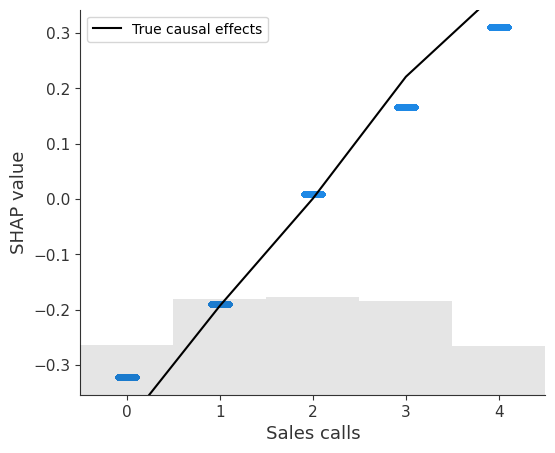

In [27]:
# Fit, explain, and plot a univariate model with just Sales calls
# Note how this model does not have to split of credit between Sales calls and
# Interactions, so we get a better agreement with the true causal effect.
sales_calls_model = fit_xgboost(X[["Sales calls"]], y)
sales_calls_shap_values = shap.Explainer(sales_calls_model)(X[["Sales calls"]])
shap.plots.scatter(sales_calls_shap_values, overlay={
    "True causal effects": marginal_effects(generator, 10000, ["Sales calls"])
})